# Segment 1 Imports

In [1]:
import numpy as np  # numPy for numerical operations
import os  # Operating System module for interacting with the file system
import pandas as pd  # Pandas for data manipulation
import seaborn as sns  # Seaborn for statistical data visualization
import torch  # PyTorch, a deep learning framework
import torchvision  # PyTorch's computer vision library
from functools import partial  # Partial function application
from matplotlib import pyplot as plt  # Matplotlib for plotting
from random import randrange  # Random number generation
from ray import tune  # Ray for distributed computing and hyperparameter tuning
from ray.tune import CLIReporter  # Command-line interface reporter for Ray Tune
from ray.tune.schedulers import HyperBandForBOHB, ASHAScheduler  # Hyperparameter tuning schedulers
from tabulate import tabulate  # Pretty-print tabular data
from torch import nn, optim  # PyTorch's neural network and optimization modules
from torch.nn import functional as F  # PyTorch's functional interface
from torch.utils.data import random_split  # Splitting datasets
from torch.utils.data.sampler import SubsetRandomSampler  # Subset sampling
from torchsummary import summary  # Model summary generation

# Segment 2 Using CPU if GPU isnt available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Use GPU if available for MAC pc

# Segment 3 Data Transformations 

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),`
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
])
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
validationset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Segment 4 Display dataset information 

In [4]:
print('Training set')
print(f'Samples: {trainset.data.shape}')
print(f'Labels: {len(trainset.targets)}')
print('\nTest set')
print(f'Samples: {testset.data.shape}')
print(f'Labels: {len(testset.targets)}')
print('\nClasses\n')
print(tabulate(
    list(trainset.class_to_idx.items()), headers=['Name', 'Index'],
    tablefmt='orgtbl'
))


Training set
Samples: (50000, 32, 32, 3)
Labels: 50000

Test set
Samples: (10000, 32, 32, 3)
Labels: 10000

Classes

| Name       |   Index |
|------------+---------|
| airplane   |       0 |
| automobile |       1 |
| bird       |       2 |
| cat        |       3 |
| deer       |       4 |
| dog        |       5 |
| frog       |       6 |
| horse      |       7 |
| ship       |       8 |
| truck      |       9 |


# Segment 5 Display random images from the training set and their label

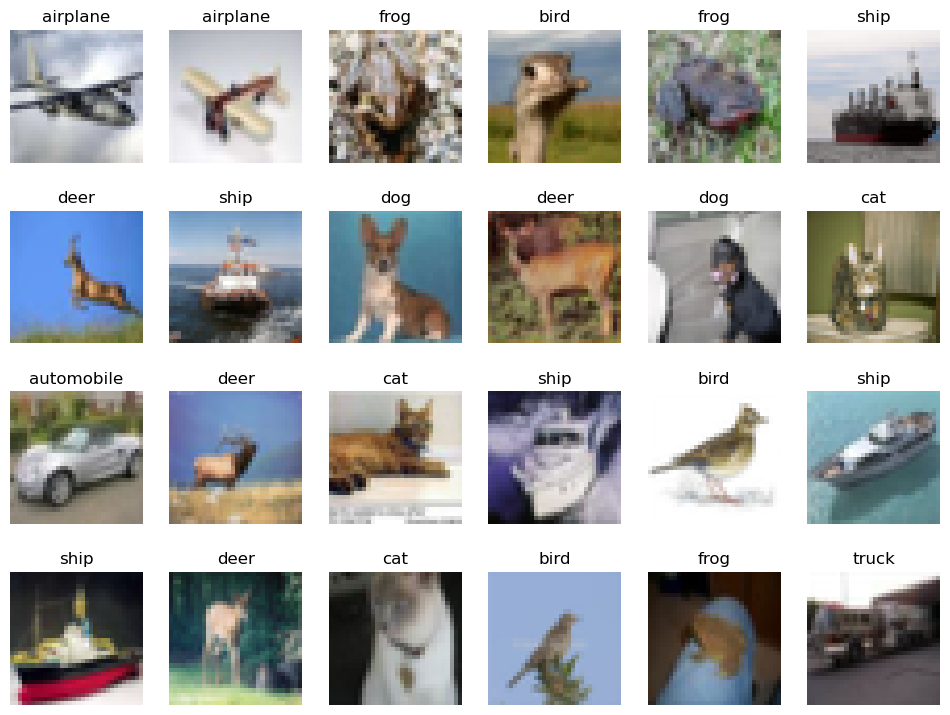

In [5]:
IDX_TO_LABEL = {v: k for k, v in trainset.class_to_idx.items()}
cols = 6
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(12, 9))
for x in range(rows):
    for y in range(cols):
        rnd_idx = randrange(len(trainset.data))
        axs[x, y].set_title(IDX_TO_LABEL[trainset.targets[rnd_idx]])
        axs[x, y].imshow(trainset.data[rnd_idx])
        axs[x, y].set_axis_off()
plt.show()

# Segment 6 Define the ResNet model

In [6]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ), nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        ), nn.Sequential( 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), 
            nn.Flatten(), 
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.classifier(x)
        
        return x

# Segment 7 Creating an instance of the ResNet model and printing its summary

In [7]:
from torchsummary import summary
net = ResNet()
net = net.to(device)
summary(net, (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,792
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4          [32, 128, 32, 32]          73,856
       BatchNorm2d-5          [32, 128, 32, 32]             256
              ReLU-6          [32, 128, 32, 32]               0
         MaxPool2d-7          [32, 128, 16, 16]               0
            Conv2d-8          [32, 128, 16, 16]         147,584
       BatchNorm2d-9          [32, 128, 16, 16]             256
             ReLU-10          [32, 128, 16, 16]               0
           Conv2d-11          [32, 128, 16, 16]         147,584
      BatchNorm2d-12          [32, 128, 16, 16]             256
             ReLU-13          [32, 128, 16, 16]               0
           Conv2d-14          [32, 256,

# Segment 8 Define data loaders for training, validation, and testing

In [8]:
valid_size = 0.2
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
TRAIN_SAMPLER = SubsetRandomSampler(train_idx)
VALID_SAMPLER = SubsetRandomSampler(valid_idx)
NUM_WORKERS = 2

def data_loaders(trainset, validationset, testset, size):
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=size,
        sampler=TRAIN_SAMPLER, num_workers=NUM_WORKERS
    )
    validloader = torch.utils.data.DataLoader(
        validationset, batch_size=size,
        sampler=VALID_SAMPLER, num_workers=NUM_WORKERS
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=size, num_workers=NUM_WORKERS
    )
    return trainloader, validloader, testloader

# Segment 9 Define the training function for the ResNet model


In [9]:
def train_cifar(
    config, trainset, validationset, testset, 
    epochs=15, checkpoint_dir=None, tuning=False
):
    net = ResNet()
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        net.parameters(), 
        lr=config['lr'], 
        betas=(config['beta1'], config['beta2']), 
        amsgrad=config['amsgrad'], 
    )

    # The `checkpoint_dir` parameter gets passed by Ray Tune when a checkpoint
    # should be restored
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, 'checkpoint')
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainloader, validloader, testloader = data_loaders(
        trainset, validationset, testset, config['batch_size']
    )

    train_loss_list = []
    accuracy_list = []

    # track minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(epochs):
        
        train_loss = 0.0
        net.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        correct = 0
        valid_loss = 0.0
        net.eval()
        for inputs, labels in validloader:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                predicted = torch.max(outputs.data, 1)[1]

                correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(TRAIN_SAMPLER)
        valid_loss = valid_loss / len(VALID_SAMPLER)
        accuracy = correct / len(VALID_SAMPLER)

        train_loss_list.append(train_loss)
        accuracy_list.append(accuracy)

        if not tuning:
            print(
                f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \t'
                f'Validation Loss: {valid_loss:.6f} \t'
                f'Validation Accuracy: {accuracy:.6f}'
            )

            if valid_loss <= valid_loss_min:
                print(
                    'Validation loss decreased ('
                    f'{valid_loss_min:.6f} --> {valid_loss:.6f}).  '
                    'Saving model ...'
                )

                torch.save(net.state_dict(), 'cnn.pt')
                valid_loss_min = valid_loss
        else:
            with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((net.state_dict(), optimizer.state_dict()), path)

            tune.report(mean_loss=valid_loss, accuracy=accuracy)

    print('\n----------- Finished Training -----------')

    return train_loss_list, accuracy_list

# Segment 10 Set up the configuration dictionary for training


In [10]:
config = {
    'lr': 0.001,
    'beta1': 0.9,
    'beta2': 0.999,
    'amsgrad': False,
    'batch_size': 64,
}
epochs = 15
train_loss_list, accuracy_list = train_cifar(
    config, trainset, validationset, testset,
    epochs=epochs, tuning=False
)

Epoch: 0 	Training Loss: 1.252068 	Validation Loss: 0.868149 	Validation Accuracy: 0.693300
Validation loss decreased (inf --> 0.868149).  Saving model ...
Epoch: 1 	Training Loss: 0.772773 	Validation Loss: 0.705577 	Validation Accuracy: 0.759200
Validation loss decreased (0.868149 --> 0.705577).  Saving model ...
Epoch: 2 	Training Loss: 0.623243 	Validation Loss: 0.679657 	Validation Accuracy: 0.776500
Validation loss decreased (0.705577 --> 0.679657).  Saving model ...
Epoch: 3 	Training Loss: 0.532175 	Validation Loss: 0.625333 	Validation Accuracy: 0.791600
Validation loss decreased (0.679657 --> 0.625333).  Saving model ...
Epoch: 4 	Training Loss: 0.467154 	Validation Loss: 0.468303 	Validation Accuracy: 0.838900
Validation loss decreased (0.625333 --> 0.468303).  Saving model ...
Epoch: 5 	Training Loss: 0.414105 	Validation Loss: 0.496680 	Validation Accuracy: 0.836200
Epoch: 6 	Training Loss: 0.379515 	Validation Loss: 0.470858 	Validation Accuracy: 0.839300
Epoch: 7 	Traini

# Segment 11 Load test data

In [11]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=32)
images, labels = next(iter(test_loader))

# Segment 12 Load the trained model

In [12]:
net.load_state_dict(torch.load('cnn.pt'))
net.to(device)
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

# Segment 13 Extract features from the test data using the trained model

In [13]:
features = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        feature_batch = net(x)
        features.append(feature_batch.cpu().numpy())

# Segment 14 Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

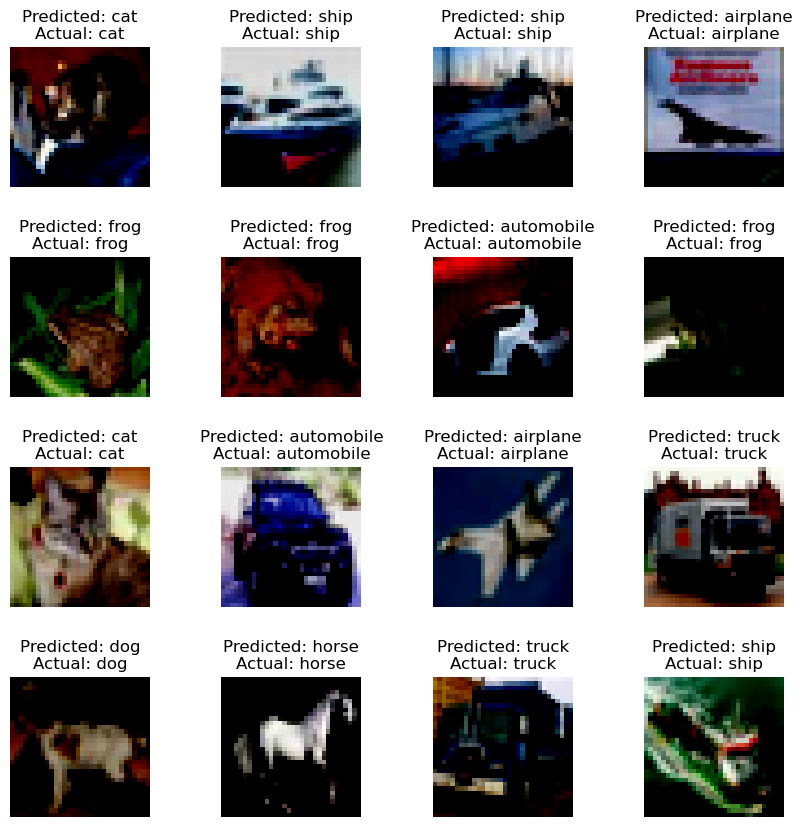

In [14]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
fig, axs = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
for i in range(4):
    for j in range(4):
        if predicted[i*4+j] == labels[i*4+j]:
            color = 'black'
        else:
            color = 'red'
        axs[i, j].set_title(f"Predicted: {CLASS_NAMES[predicted[i*4+j]]}\nActual: {CLASS_NAMES[labels[i*4+j]]}", color=color)
        axs[i, j].imshow(images[i*4+j].permute(1, 2, 0))
        axs[i, j].axis('off')
plt.show()

# Plotting Loss and Accuracy + T-SNE plot

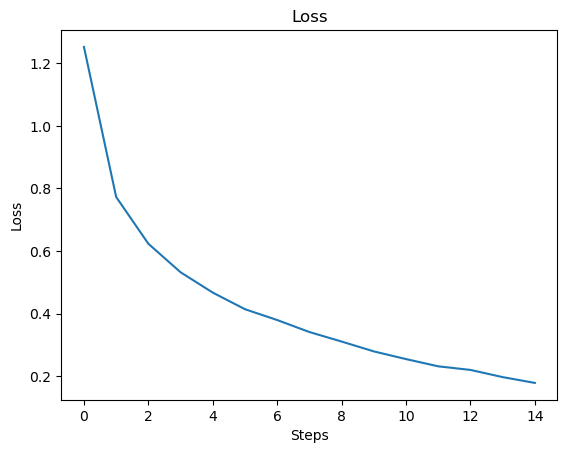

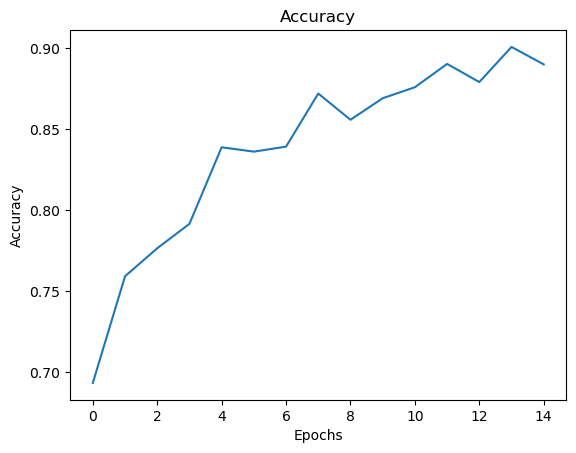

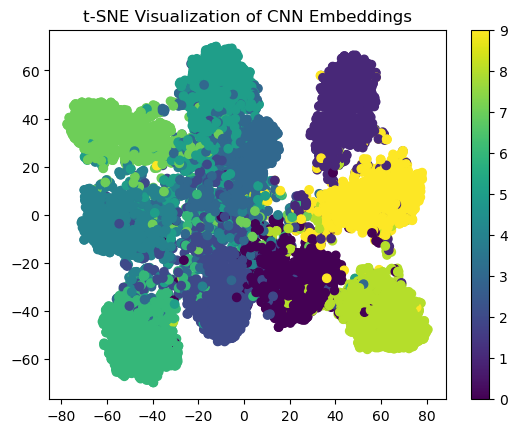

In [16]:
from sklearn.manifold import TSNE

# Plot loss and accuracy        
plt.plot(train_loss_list)
plt.title('Loss') 
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracy_list)  
plt.title('Accuracy')
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.show()

# Extract embeddings and visualize with t-SNE
embeddings = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        embeddings.append(outputs.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

# Concatenate embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=30.0, random_state=42)
X_tsne = tsne.fit_transform(embeddings)

# Plot the t-SNE graph with colored points
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=true_labels)
plt.colorbar()
plt.title('t-SNE Visualization of CNN Embeddings')
plt.show()